In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [61]:
%matplotlib inline

In [62]:
s = pd.read_csv("PDBbind2015_refined-core.dat",delimiter='\s+')
print (s)

       affinity     score     gauss1      gauss2  repulsion  hydrophobic  \
0     -2.745424  -3.13245   48.02108   434.90009    1.00229     17.16027   
1     -2.745424  -4.57551   45.86394   906.54910    4.54990      0.00000   
2     -2.745424  -4.58830   49.45446   708.90695    4.56065     10.12192   
3     -2.745424  -3.13634   54.99922   768.05907    5.70052     31.01157   
4     -2.814060  -5.04353   53.45864  1053.90858    1.63114      0.00000   
5     -2.910150  -6.74904  113.76903  1481.08181    8.93015      4.11732   
6     -2.910150  -4.16492   42.29731   660.09223    3.00852      8.73834   
7     -2.965058  -3.76214   60.02820   726.13705    5.97046      0.00000   
8     -2.978785  -4.11913   54.80789   748.67528    3.38569     37.28263   
9     -2.992513  -9.43253  112.66393  1645.48020    3.35142     11.52286   
10    -3.006240  -5.35717   77.16599   974.24645    3.67899     26.59395   
11    -3.006240  -5.86004   72.87585   860.10664    2.22941     29.84266   
12    -3.033

In [63]:
import pymc3 as pm3
import numdifftools as ndt
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [64]:
import pymc3 as pm3
import numpy as np
import numdifftools as ndt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [65]:
import pymc3 as pm3
import numpy as np
import numdifftools as ndt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

In [66]:
df = s

In [67]:
df.describe()


,affinity,score,gauss1,gauss2,repulsion,hydrophobic,hydrogen
count,3248.000000,3248.000000,3248.000000,3248.000000,3248.000000,3248.000000,3248.000000
mean,-8.811549,-7.146752,93.867510,1347.249859,4.739716,31.802597,5.145502
std,2.729615,2.328613,35.816121,552.642367,2.606303,28.006997,3.584242
min,-16.362729,-15.398830,7.497280,269.989350,0.121460,0.000000,0.000000
25%,-10.734609,-8.691327,65.707425,937.015818,2.813320,7.389995,2.212245
50%,-8.895175,-7.134780,89.746905,1267.259360,4.309330,26.738340,4.636870
75%,-6.753744,-5.436285,117.929120,1675.342045,6.219677,49.272855,7.445367
max,-2.745424,2.620890,298.021650,4202.325050,21.601870,178.904130,22.804180


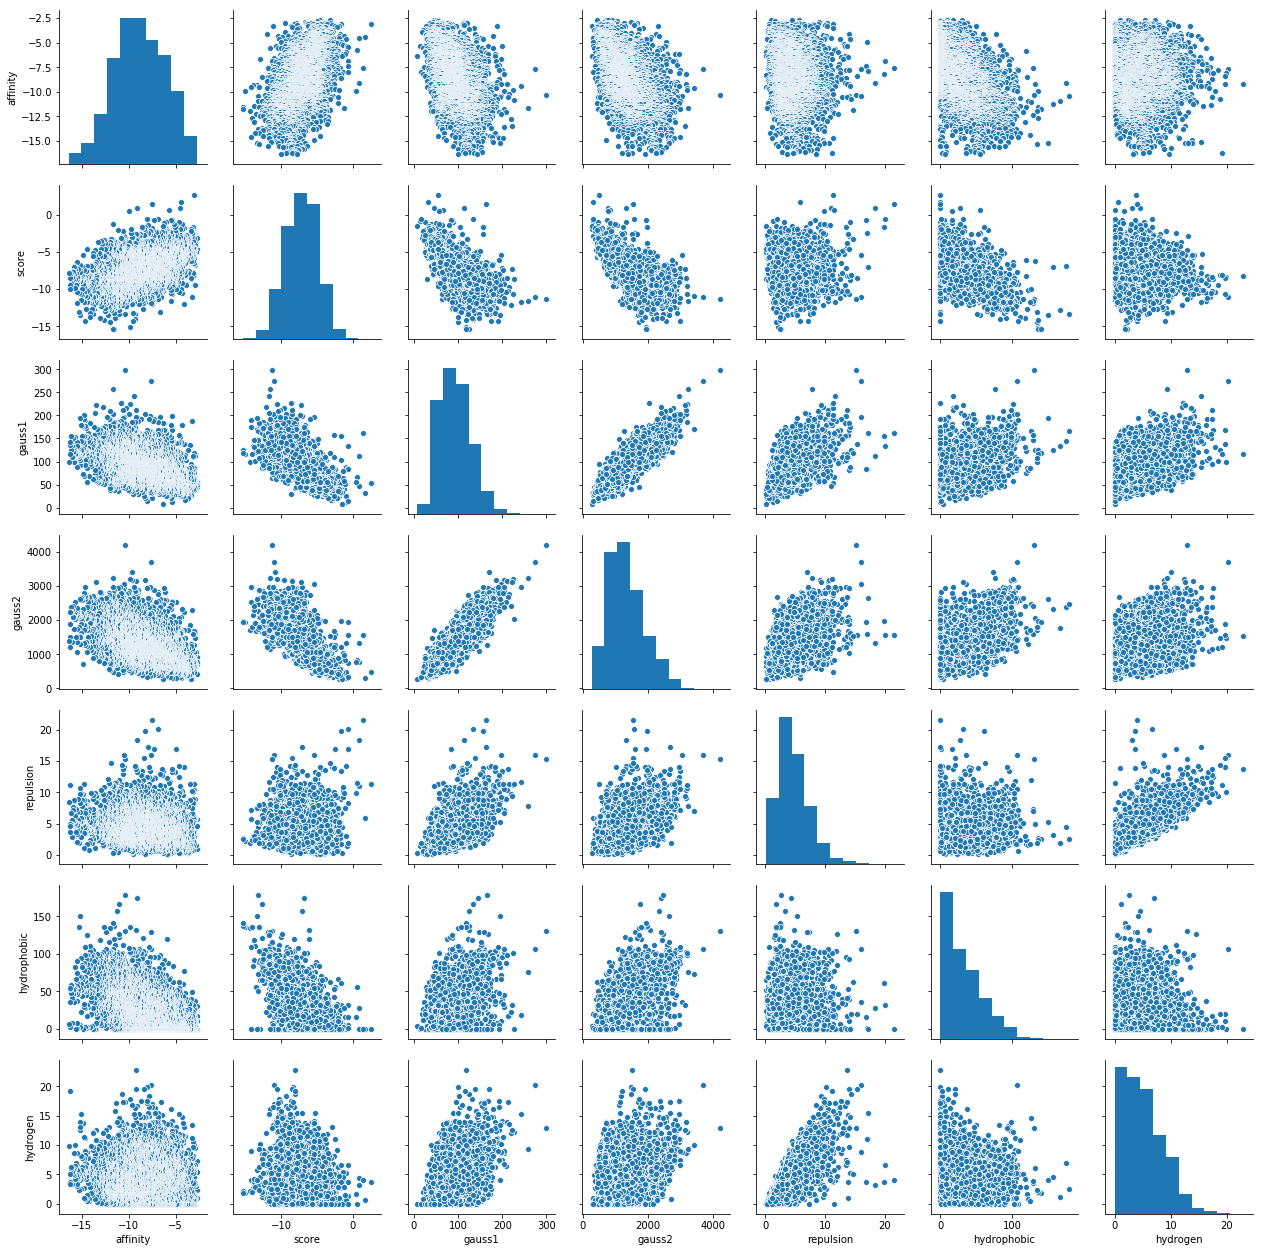

In [68]:
sns.pairplot(df)

Firstly there doesn't seem to be a linear relationship between the output and features.
Hence we may need to do non-linear regression.

There are a few points to note:
1. The data is not normalized, so we would need to normalize it.
2. There are some missing values. We should replace these with a suitable central 
   statistic.
3. Gauss1 and Gauss2 are apparently correlated, so we should check with considering them
   as one feature instead of two.
   

In [69]:
# Make two test datasets - one with same values and other with missing values
# replaced with the mean.
import copy
df1 = df.copy(deep = True)
hp_mean = df['hydrophobic'].mean()
df['hydrophobic']=df.hydrophobic.mask(df.hydrophobic == 0,hp_mean)
hd_mean = df['hydrogen'].mean()
df['hydrogen']=df.hydrogen.mask(df.hydrogen == 0,hd_mean)


# Normalizing the data using min-max normalization
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df1=(df1-df1.min())/(df1.max()-df1.min())

normalized_df.describe()
normalized_df['affinity'].corr(normalized_df['score'])


0.4699338551068132
































# Currently, the correlation between actual and predicted values is 0.46.

In [70]:
# Import function to create training and test set splits
from sklearn.cross_validation import train_test_split
# Import function to automatically create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline

# Regularization (Lasso) and Cross - Validation for increasing powers of features :

In [71]:
X = normalized_df[['gauss1','gauss2','repulsion','hydrophobic','hydrogen']]
y = normalized_df['affinity']
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.01
lasso_nalpha=20
lasso_iter=20000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 5

rmse_list = []
scores_list = []

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5)
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    scores_list.append(test_score)
    rmse_list.append(RMSE)

fmodel = make_pipeline(PolynomialFeatures(3, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
fmodel.fit(X,y)

rmse_list
scores_list


[0.2740098950412495,
 0.31315108374324274,
 0.30387809189425796,
 0.29613722740427195,
 0.29128864646763275]

In [72]:
"""
Treating missing values as actual values - ie without replacing 0 by mean : 
"""

X = normalized_df1[['gauss1','gauss2','repulsion','hydrophobic','hydrogen']]
y = normalized_df1['affinity']
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.01
lasso_nalpha=20
lasso_iter=20000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 5

rmse_list = []
scores_list = []

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5)
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    scores_list.append(test_score)
    rmse_list.append(RMSE)
rmse_list
scores_list


[0.2802289944406181,
 0.34045554144744095,
 0.3398452954064263,
 0.3354003922105663,
 0.33103478155255983]

**Upon comparing the two cells above, we find that replacing the missing values by mean gives
a slightly lesser score ( R - squared ), so we stick to the one with missing values not replaced and select n = 3 as the degree as after 3, the cross validation score decreases.**


_Reasons for choosing LASSO :_ 

Using LASSO regression, we are eliminating the higher-order terms in the more complex models. Effectively, this does the ‘automatic feature selection’ i.e.automatically ignores the unimportant features even if we start with a highly complex model to fit the data.

Noise makes it hard for the model to be bias-free and it also pushes the model towards overfitting because the model tries to makes sense of the noisy data patterns and instead of discovering the real pattern, fits to noise. Basically, the simple linear regression model (w/o regularization) can fail miserable in this condition. 

In [73]:
"""
Now finally we try to make a new feature out of Gauss1 and Gauss2 by taking their mean and 
check its performance.
"""


new_col = (normalized_df1['gauss1'] + normalized_df1['gauss2'])/2.0 
temporary_df1 = normalized_df1.copy(deep=True)
temporary_df1['gauss1'] = new_col

X = temporary_df1[['gauss1','repulsion','hydrophobic','hydrogen']]
y = temporary_df1['affinity']
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.01
lasso_nalpha=20
lasso_iter=20000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 5

rmse_list = []
scores_list = []

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.5)
# Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,
normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    scores_list.append(test_score)
    rmse_list.append(RMSE)
rmse_list
scores_list



[0.2741339520073761,
 0.3201185016911213,
 0.32020495966600326,
 0.3181374724553192,
 0.3192518669152874]



























After running for a few iterations, we see there is no significant increase in the score 
and hence we do not accept this model.

__Finally, our model is the one with original features and degree of features used in polynomial regression = 3.__


In [74]:
"""
Output Code:
"""

#enter the output file name in the following line:
ss  = pd.read_csv("PDBbind2015_refined-core.dat",delimiter='\s+')

dff = ss

#normalization
normalized_dff=(dff-dff.min())/(dff.max()-dff.min())
#prediction 


X_eval = normalized_dff[['gauss1','gauss2','repulsion','hydrophobic','hydrogen']]
eval_pred   = (fmodel.predict(X_eval.iloc[:]))

print(np.corrcoef(eval_pred,normalized_dff['affinity'])[0][1])

"""
The normalized prediction is in eval_pred, normalized output is in normalized_dff['affinity']
Enter evaluation metric here to compare the two.
"""



0.5686859490869688


"\nThe normalized prediction is in eval_pred, normalized output is in normalized_dff['affinity']\nEnter evaluation metric here to compare the two.\n"